# **NLP Model (BERT) for Fake News Detection**

In [4]:
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/1

In [1]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

device = torch.device("cuda")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/NLP_SDAI_Project

/content/drive/MyDrive/NLP_SDAI_Project


## Dataset Preparation

In [53]:
true_data = pd.read_csv('true.csv')
fake_data = pd.read_csv('fake.csv')

#generate labels True/Fake under new label column
true_data['label'] = ['True']*len(true_data)
fake_data['label'] = ['Fake']*len(fake_data)

#merge into a single df
data = true_data._append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,label
0,Trevor Noah Brutally Dropkicks Ted Cruz For H...,Daily Show host Trevor Noah got brutal with Te...,News,"March 25, 2016",Fake
1,BREAKING: TWO Suspects In Dallas Cop Shootings...,Two suspects are in DPD custody following horr...,left-news,"Jul 8, 2016",Fake
2,Mexico presidency hopeful eyes tax cuts to cou...,MONTERREY (Reuters) - A Mexican presidential h...,worldnews,"December 5, 2017",True
3,"Factbox: Trump budget boosts military, slashes...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 16, 2017",True
4,Obamacare taxes stand if Senate fails to adopt...,WASHINGTON (Reuters) - Nearly $1 trillion of t...,politicsNews,"June 26, 2017",True


In [59]:
#change labels to numbers 0/1 (Fake=1)l
data['value'] = pd.get_dummies(data['label'])['Fake'].astype(int)

In [60]:
data.head()

,title,text,subject,date,label,value
0,Trevor Noah Brutally Dropkicks Ted Cruz For H...,Daily Show host Trevor Noah got brutal with Te...,News,"March 25, 2016",Fake,1
1,BREAKING: TWO Suspects In Dallas Cop Shootings...,Two suspects are in DPD custody following horr...,left-news,"Jul 8, 2016",Fake,1
2,Mexico presidency hopeful eyes tax cuts to cou...,MONTERREY (Reuters) - A Mexican presidential h...,worldnews,"December 5, 2017",True,0
3,"Factbox: Trump budget boosts military, slashes...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 16, 2017",True,0
4,Obamacare taxes stand if Senate fails to adopt...,WASHINGTON (Reuters) - Nearly $1 trillion of t...,politicsNews,"June 26, 2017",True,0


In [61]:
#train-validation-test set split into 70:15:15 ratio
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['value'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## Loading BERT and Training

In [62]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of texts')

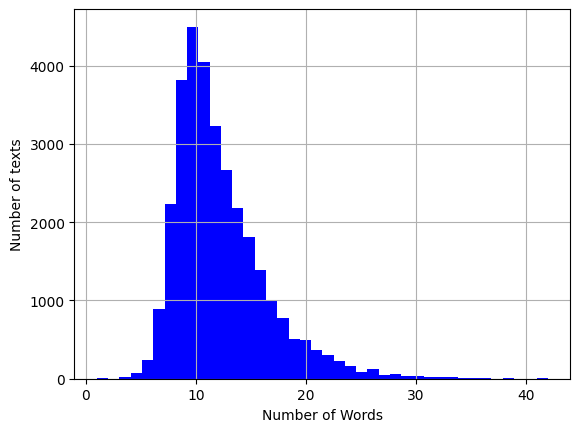

In [63]:
#histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [64]:
#majority of the titles have word length under 15. So, we set max title length as 15
MAX_LENGTH = 15
#tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
#tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
#tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)

In [65]:
#convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [66]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [67]:
for param in bert.parameters():
    param.requires_grad = False

In [68]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

model = BERT_Arch(bert)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)
cross_entropy  = nn.NLLLoss()
epochs = 2

In [69]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels.long())
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels.long())
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

In [70]:
#train and predict
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.561
Validation Loss: 0.485

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

## Model Performance

In [110]:
path = 'best_model.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [111]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')

    plt.colorbar(cax)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

In [112]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3212
           1       0.92      0.87      0.89      3523

    accuracy                           0.89      6735
   macro avg       0.89      0.89      0.89      6735
weighted avg       0.89      0.89      0.89      6735



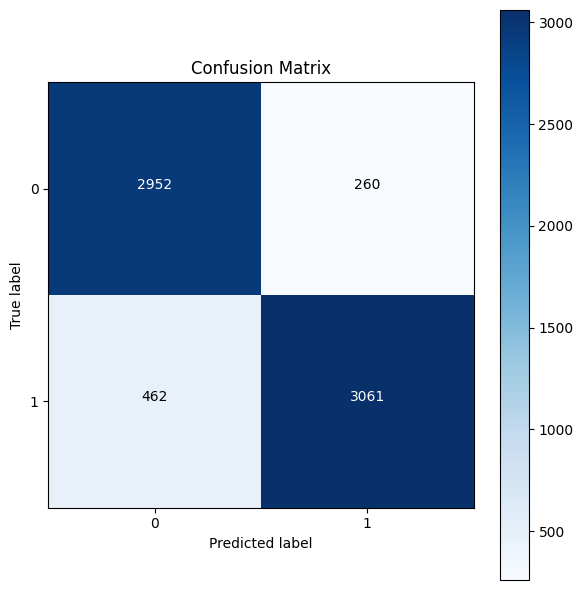

In [113]:
classes = np.unique(test_y)
plot_confusion_matrix(test_y, preds, classes)